In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from glob import glob
from matplotlib.backends.backend_pdf import PdfPages
from astropy import units as u
from astropy.coordinates import SkyCoord
#pd.options.mode.copy_on_write = True
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import multiprocessing as mp
from tqdm import tqdm
cosmo = FlatLambdaCDM(name='Planck18', H0=67.66, Om0=0.30966, Tcmb0=2.7255, Neff=3.046, m_nu=[0.  , 0.  , 0.06]* u.eV, Ob0=0.04897)
cores = 8
plt.style.use('ggplot')

In [2]:
from desispec.io import read_spectra
from desitrip.preproc import rebin_flux, rescale_flux

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow
from joblib import Parallel, delayed

from astropy.table import Table

import os
import shutil
import platform

import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

mpl.rc('font', size=14)

2024-10-15 22:05:55.213140: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 22:05:55.598904: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 22:05:55.599544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 22:06:05.992387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [4]:
minw, maxw, nbins = 2500., 9000., 160

In [5]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        try:
            truez = truth['TRUEZ']
        except:
            print(truth)
            print(cf, tf)

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=minw, maxwave=maxw, nbins=nbins, log=True, clip=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    return fluxes

In [6]:
def drop_nan(mytable):
    has_nan = np.zeros(len(mytable), dtype=bool)
    for col in mytable.itercols():
        if col.info.dtype.kind == 'f':
            has_nan |= np.isnan(col)
    mytable_no_nan = mytable[~has_nan]
    return mytable_no_nan

In [7]:
def condition_tde(coadd_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of ascii files
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = []
    
    for cf in coadd_files:
        which = len(Table.read(cf, format = "ascii").colnames)
        if(which == 3):
            spectra = drop_nan(Table.read(cf, format = "ascii", names = ["wave", "flux", "flux_err"]))
            wave = spectra["wave"]
            flux = spectra["flux"]
            ivar = spectra["flux_err"]
        elif(which == 6):
            spectra = drop_nan(Table.read(cf, format = "ascii", names = ["wave", "flux", "sky_flux", "flux_err", "xpixel", "ypixel", "resopnse"]))
            wave = spectra["wave"]
            flux = spectra["flux"]
            ivar = spectra["flux_err"]
        elif(which == 2):
            spectra = drop_nan(Table.read(cf, format = "ascii", names = ["wave", "flux"]))
            wave = spectra["wave"]
            flux = spectra["flux"]
            ivar = None

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, minwave=minw, maxwave=maxw, nbins=nbins, log=True, clip=True)
        rsflux = rescale_flux(reflux)

        fluxes.append(rsflux)
    return fluxes

In [8]:
path_to_bgs = '/global/cfs/cdirs/desi/science/td/sim/bgs'

In [9]:
tde_files = sorted(glob("TDE_Spectra/*.ascii"))
tde_flux = np.asarray(condition_tde(tde_files))
tde_flux.shape

(56, 160)

In [10]:
tde_files_2 = sorted(glob("TDE_Spectra_class/*.ascii"))
tde_flux_2 = np.asarray(condition_tde(tde_files_2))
np.save("tde_flux_2", tde_flux_2)
tde_flux_2.shape

(27, 160)

In [11]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message='.*read_spectra.*')

In [12]:
galaxy_truth = sorted(glob('{}/150s/hosts/*truth.fits'.format(path_to_bgs)))
galaxy_coadd = sorted(glob('{}/150s/hosts/*coadd.fits'.format(path_to_bgs)))
galaxy_flux  = condition_spectra(galaxy_coadd, galaxy_truth)

INFO:spectra.py:391:read_spectra: iotime 0.149 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2024-10-07T09:49:07.682900
INFO:spectra.py:391:read_spectra: iotime 0.132 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2024-10-07T09:49:07.995725
INFO:spectra.py:391:read_spectra: iotime 0.149 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2024-10-07T09:49:08.317619
INFO:spectra.py:391:read_spectra: iotime 0.137 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2024-10-07T09:49:08.631339
INFO:spectra.py:391:read_spectra: iotime 0.156 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2024-10-07T09:49:08.961637
INFO:spectra.py:391:read_spectra: iotime 0.150 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2024-10-07T09:49:09.281842
INFO:spectra.py:391:read_spectra: iotime 0.141 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2024-10-07T09:49:09.600360
INFO:spectra.py:391:read_spectra: iotime 0.153 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2024-10-07T09:49:09.921454


In [13]:
snia_truth = sorted(glob('{}/150s/sn_ia/hsiao/*truth.fits'.format(path_to_bgs)))
snia_files = sorted(glob('{}/150s/sn_ia/hsiao/*coadd.fits'.format(path_to_bgs)))
snia_flux  = condition_spectra(snia_files, snia_truth)

INFO:spectra.py:391:read_spectra: iotime 0.152 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2024-10-07T09:49:45.356209
INFO:spectra.py:391:read_spectra: iotime 0.140 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2024-10-07T09:49:45.674517
INFO:spectra.py:391:read_spectra: iotime 0.200 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2024-10-07T09:49:46.066407
INFO:spectra.py:391:read_spectra: iotime 0.155 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2024-10-07T09:49:46.429222
INFO:spectra.py:391:read_spectra: iotime 0.148 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2024-10-07T09:49:46.761676
INFO:spectra.py:391:read_spectra: iotime 0.156 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2024-10-07T09:49:47.104994
INFO:spectra.py:391:read_spectra: iotime 0.177 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2024-10-07T09:49:47.460025
INFO:spectra.py:391:read_spectra: iotime 0.137 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2024-10-07T09:49:47.804862


In [14]:
snib_truth = sorted(glob('{}/150s/sn_ib/*/*truth.fits'.format(path_to_bgs)))
snib_files = sorted(glob('{}/150s/sn_ib/*/*coadd.fits'.format(path_to_bgs)))
snib_flux  = condition_spectra(snib_files, snib_truth)

INFO:spectra.py:391:read_spectra: iotime 0.168 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-10-07T09:50:19.892151
INFO:spectra.py:391:read_spectra: iotime 0.130 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-10-07T09:50:20.209871
INFO:spectra.py:391:read_spectra: iotime 0.139 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-10-07T09:50:20.551734
INFO:spectra.py:391:read_spectra: iotime 0.148 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-10-07T09:50:20.867952
INFO:spectra.py:391:read_spectra: iotime 0.144 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-10-07T09:50:21.187788
INFO:spectra.py:391:read_spectra: iotime 0.139 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-10-07T09:50:21.532963
INFO:spectra.py:391:read_spectra: iotime 0.131 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-10-07T09:50:21.846696
INFO:spectra.py:391:read_spectra: iotime 0.149 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-10-07T09:50:22.165040


In [15]:
snibc_truth = sorted(glob('{}/150s/sn_ibc/*/*truth.fits'.format(path_to_bgs)))
snibc_files = sorted(glob('{}/150s/sn_ibc/*/*coadd.fits'.format(path_to_bgs)))
snibc_flux  = condition_spectra(snibc_files, snibc_truth)

INFO:spectra.py:391:read_spectra: iotime 0.205 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-10-07T09:50:59.245072
INFO:spectra.py:391:read_spectra: iotime 0.163 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-10-07T09:50:59.601198
INFO:spectra.py:391:read_spectra: iotime 0.151 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-10-07T09:50:59.945238
INFO:spectra.py:391:read_spectra: iotime 0.138 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-10-07T09:51:00.303865
INFO:spectra.py:391:read_spectra: iotime 0.148 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-10-07T09:51:00.702713
INFO:spectra.py:391:read_spectra: iotime 0.170 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-10-07T09:51:01.038508
INFO:spectra.py:391:read_spectra: iotime 0.200 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-10-07T09:51:01.442711
INFO:spectra.py:391:read_spectra: iotime 0.137 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-10-07T09:51:01.767321


In [16]:
snic_truth = sorted(glob('{}/150s/sn_ic/*/*truth.fits'.format(path_to_bgs)))
snic_files = sorted(glob('{}/150s/sn_ic/*/*coadd.fits'.format(path_to_bgs)))
snic_flux  = condition_spectra(snic_files, snic_truth)

INFO:spectra.py:391:read_spectra: iotime 0.161 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-10-07T09:51:34.411950
INFO:spectra.py:391:read_spectra: iotime 0.154 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-10-07T09:51:34.737868
INFO:spectra.py:391:read_spectra: iotime 0.137 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-10-07T09:51:35.039730
INFO:spectra.py:391:read_spectra: iotime 0.173 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-10-07T09:51:35.387708
INFO:spectra.py:391:read_spectra: iotime 0.200 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-10-07T09:51:35.778636
INFO:spectra.py:391:read_spectra: iotime 0.141 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-10-07T09:51:36.087687
INFO:spectra.py:391:read_spectra: iotime 0.160 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-10-07T09:51:36.417379
INFO:spectra.py:391:read_spectra: iotime 0.169 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-10-07T09:51:36.767992


In [17]:
sniin_truth = sorted(glob('{}/150s/sn_iin/*/*truth.fits'.format(path_to_bgs)))
sniin_files = sorted(glob('{}/150s/sn_iin/*/*coadd.fits'.format(path_to_bgs)))
sniin_flux  = condition_spectra(sniin_files, sniin_truth)

INFO:spectra.py:391:read_spectra: iotime 0.131 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-10-07T09:52:03.324769
INFO:spectra.py:391:read_spectra: iotime 0.206 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-10-07T09:52:03.711518
INFO:spectra.py:391:read_spectra: iotime 0.139 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-10-07T09:52:04.059581
INFO:spectra.py:391:read_spectra: iotime 0.148 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-10-07T09:52:04.379196
INFO:spectra.py:391:read_spectra: iotime 0.180 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-10-07T09:52:04.730587
INFO:spectra.py:391:read_spectra: iotime 0.158 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-10-07T09:52:05.251708
INFO:spectra.py:391:read_spectra: iotime 0.140 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-10-07T09:52:05.565826
INFO:spectra.py:391:read_spectra: iotime 0.228 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-10-07T09:52:05.980579


In [18]:
sniilp_truth = sorted(glob('{}/150s/sn_iilp/*/*truth.fits'.format(path_to_bgs)))
sniilp_files = sorted(glob('{}/150s/sn_iilp/*/*coadd.fits'.format(path_to_bgs)))
sniilp_flux  = condition_spectra(sniilp_files, sniilp_truth)

INFO:spectra.py:391:read_spectra: iotime 0.158 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-10-07T09:52:38.354853
INFO:spectra.py:391:read_spectra: iotime 0.140 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-10-07T09:52:38.662721
INFO:spectra.py:391:read_spectra: iotime 0.182 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-10-07T09:52:39.045643
INFO:spectra.py:391:read_spectra: iotime 0.138 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-10-07T09:52:39.357980
INFO:spectra.py:391:read_spectra: iotime 0.146 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-10-07T09:52:39.682848
INFO:spectra.py:391:read_spectra: iotime 0.136 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-10-07T09:52:39.990155
INFO:spectra.py:391:read_spectra: iotime 0.173 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-10-07T09:52:40.338419
INFO:spectra.py:391:read_spectra: iotime 0.151 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-10-07T09:52:40.659306


In [19]:
sniip_truth = sorted(glob('{}/150s/sn_iip/*/*truth.fits'.format(path_to_bgs)))
sniip_files = sorted(glob('{}/150s/sn_iip/*/*coadd.fits'.format(path_to_bgs)))
sniip_flux  = condition_spectra(sniip_files, sniip_truth)

INFO:spectra.py:391:read_spectra: iotime 0.174 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2024-10-07T09:53:12.433818
INFO:spectra.py:391:read_spectra: iotime 0.157 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2024-10-07T09:53:12.810823
INFO:spectra.py:391:read_spectra: iotime 0.144 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2024-10-07T09:53:13.136635
INFO:spectra.py:391:read_spectra: iotime 0.141 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2024-10-07T09:53:13.447114
INFO:spectra.py:391:read_spectra: iotime 0.159 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2024-10-07T09:53:13.787066
INFO:spectra.py:391:read_spectra: iotime 0.175 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2024-10-07T09:53:14.159211
INFO:spectra.py:391:read_spectra: iotime 0.148 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2024-10-07T09:53:14.492552
INFO:spectra.py:391:read_spectra: iotime 0.154 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2024-10-07T09:53:14.830805


In [20]:
kn_truth = sorted(glob('{}/180s/kn/*/*/*truth.fits'.format(path_to_bgs)))
kn_files = sorted(glob('{}/180s/kn/*/*/*coadd.fits'.format(path_to_bgs)))

In [21]:
print('kn_truth len: {}'.format((len(kn_truth))))
print('snia_truth len: {}'.format(len(snia_truth)))
print('kn_files len: {}'.format(len(kn_files)))
print('snia_files len: {}'.format(len(snia_files)))
print('snia_flux len: {}'.format(len(snia_flux)))

kn_truth len: 9415
snia_truth len: 100
kn_files len: 8978
snia_files len: 100
snia_flux len: 9964


In [22]:
def condition_parallel(njobs, files, truth):
    all_files = np.array_split(files, njobs)
    all_truth = np.array_split(truth, njobs)
    return Parallel(n_jobs=njobs)(delayed(condition_spectra)(all_files[i], all_truth[j]) for i, j in zip(range(njobs), range(njobs)))

flux = condition_parallel(12, kn_files, kn_truth)

INFO:spectra.py:391:read_spectra: iotime 0.037 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:19.364730
INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:19.374212
INFO:spectra.py:391:read_spectra: iotime 0.046 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:19.374732
INFO:spectra.py:391:read_spectra: iotime 0.046 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:19.375524
INFO:spectra.py:391:read_spectra: iotime 0.047 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:19.375979
INFO:spectra.py:391:read_spectra: iotime 0.048 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:19.376793
INFO:spectra.py:391:read_spectra: iotime 0.049 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:19.377818
INFO:spectra.py:391:read_spectra: iotime 0.052 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:19.380960


INFO:spectra.py:391:read_spectra: iotime 0.042 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:19.566889
INFO:spectra.py:391:read_spectra: iotime 0.039 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:19.567084
INFO:spectra.py:391:read_spectra: iotime 0.039 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:19.569450
INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:19.572032
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:19.581831
INFO:spectra.py:391:read_spectra: iotime 0.042 sec to read bgs_2020-08-13_0180s_003_coadd.fits at 2024-10-07T09:54:19.583938
INFO:spectra.py:391:read_spectra: iotime 0.046 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:19.585901
INFO:spectra.py:391:read_spectra: iotime 0.048 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:19.616786


INFO:spectra.py:391:read_spectra: iotime 0.054 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:19.978825
INFO:spectra.py:391:read_spectra: iotime 0.054 sec to read bgs_2020-08-13_0180s_005_coadd.fits at 2024-10-07T09:54:20.000021
INFO:spectra.py:391:read_spectra: iotime 0.025 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:20.000308
INFO:spectra.py:391:read_spectra: iotime 0.049 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:20.009497
INFO:spectra.py:391:read_spectra: iotime 0.039 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:20.012628
INFO:spectra.py:391:read_spectra: iotime 0.044 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:20.027284
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:20.028194
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:20.029421


INFO:spectra.py:391:read_spectra: iotime 0.042 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:20.401051
INFO:spectra.py:391:read_spectra: iotime 0.050 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:20.411256
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:20.417651
INFO:spectra.py:391:read_spectra: iotime 0.038 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:20.424486
INFO:spectra.py:391:read_spectra: iotime 0.041 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:20.430095
INFO:spectra.py:391:read_spectra: iotime 0.027 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:20.439567
INFO:spectra.py:391:read_spectra: iotime 0.051 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:20.455597
INFO:spectra.py:391:read_spectra: iotime 0.047 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:20.464696


INFO:spectra.py:391:read_spectra: iotime 0.046 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:21.221752
INFO:spectra.py:391:read_spectra: iotime 0.052 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:21.227270
INFO:spectra.py:391:read_spectra: iotime 0.048 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:21.241033
INFO:spectra.py:391:read_spectra: iotime 0.050 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:21.242139
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:21.258576
INFO:spectra.py:391:read_spectra: iotime 0.047 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:21.259588
INFO:spectra.py:391:read_spectra: iotime 0.044 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:21.262089
INFO:spectra.py:391:read_spectra: iotime 0.047 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:21.283850


INFO:spectra.py:391:read_spectra: iotime 0.050 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:21.625903
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:21.636038
INFO:spectra.py:391:read_spectra: iotime 0.026 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:21.639554
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:21.639893
INFO:spectra.py:391:read_spectra: iotime 0.050 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:21.655119
INFO:spectra.py:391:read_spectra: iotime 0.042 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:21.658425
INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:21.694555
INFO:spectra.py:391:read_spectra: iotime 0.076 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:21.698110


INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:24.306478
INFO:spectra.py:391:read_spectra: iotime 0.035 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:24.310257
INFO:spectra.py:391:read_spectra: iotime 0.035 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:24.312957
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:24.315535
INFO:spectra.py:391:read_spectra: iotime 0.038 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:24.315762
INFO:spectra.py:391:read_spectra: iotime 0.041 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:24.319123
INFO:spectra.py:391:read_spectra: iotime 0.025 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:24.321559
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:24.338282


INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:24.725994
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:24.727602
INFO:spectra.py:391:read_spectra: iotime 0.031 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:24.735029
INFO:spectra.py:391:read_spectra: iotime 0.044 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:24.736604
INFO:spectra.py:391:read_spectra: iotime 0.046 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:24.748385
INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:24.761294
INFO:spectra.py:391:read_spectra: iotime 0.042 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:24.769854
INFO:spectra.py:391:read_spectra: iotime 0.047 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:24.778236


INFO:spectra.py:391:read_spectra: iotime 0.038 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:24.949399
INFO:spectra.py:391:read_spectra: iotime 0.039 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:24.964950
INFO:spectra.py:391:read_spectra: iotime 0.036 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:24.976840
INFO:spectra.py:391:read_spectra: iotime 0.032 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:24.983793
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:24.986574
INFO:spectra.py:391:read_spectra: iotime 0.052 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:24.988760
INFO:spectra.py:391:read_spectra: iotime 0.036 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:25.000625
INFO:spectra.py:391:read_spectra: iotime 0.031 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:25.000693


INFO:spectra.py:391:read_spectra: iotime 0.038 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:25.558233
INFO:spectra.py:391:read_spectra: iotime 0.026 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:25.573537
INFO:spectra.py:391:read_spectra: iotime 0.037 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:25.581487
INFO:spectra.py:391:read_spectra: iotime 0.047 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:25.593786
INFO:spectra.py:391:read_spectra: iotime 0.037 sec to read bgs_2020-08-13_0180s_005_coadd.fits at 2024-10-07T09:54:25.605637
INFO:spectra.py:391:read_spectra: iotime 0.039 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:25.611906
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:25.613366
INFO:spectra.py:391:read_spectra: iotime 0.026 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:25.626012


INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:26.801835
INFO:spectra.py:391:read_spectra: iotime 0.048 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:26.808623
INFO:spectra.py:391:read_spectra: iotime 0.039 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:26.836369
INFO:spectra.py:391:read_spectra: iotime 0.039 sec to read bgs_2020-08-13_0180s_005_coadd.fits at 2024-10-07T09:54:26.838379
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:26.838619
INFO:spectra.py:391:read_spectra: iotime 0.025 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:26.841496
INFO:spectra.py:391:read_spectra: iotime 0.027 sec to read bgs_2020-08-13_0180s_003_coadd.fits at 2024-10-07T09:54:26.842855
INFO:spectra.py:391:read_spectra: iotime 0.047 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:26.863061


INFO:spectra.py:391:read_spectra: iotime 0.029 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:28.058576
INFO:spectra.py:391:read_spectra: iotime 0.041 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:28.073157
INFO:spectra.py:391:read_spectra: iotime 0.046 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:28.084143
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:28.088601
INFO:spectra.py:391:read_spectra: iotime 0.027 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:28.098324
INFO:spectra.py:391:read_spectra: iotime 0.051 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:28.102417
INFO:spectra.py:391:read_spectra: iotime 0.046 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:28.114286
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:28.121166


INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:28.897402
INFO:spectra.py:391:read_spectra: iotime 0.038 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:28.898002
INFO:spectra.py:391:read_spectra: iotime 0.049 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:28.905267
INFO:spectra.py:391:read_spectra: iotime 0.044 sec to read bgs_2020-08-13_0180s_005_coadd.fits at 2024-10-07T09:54:28.916000
INFO:spectra.py:391:read_spectra: iotime 0.052 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:28.926906
INFO:spectra.py:391:read_spectra: iotime 0.036 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:28.948610
INFO:spectra.py:391:read_spectra: iotime 0.044 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:28.953022
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:28.955089


RELEASE BRICKID BRICKNAME  OBJID   ... PHOTSYS DESI_TARGET BGS_TARGET MWS_TARGET
                                   ...                                          
------- ------- --------- -------- ... ------- ----------- ---------- ----------
   9999  527810  2229p365 91910501 ...       N           0          0          0
/global/cfs/cdirs/desi/science/td/sim/bgs/180s/kn/02knova_desi/02knova_desi_t5.45/bgs_2020-08-13_0180s_001_coadd.fits /global/cfs/cdirs/desi/science/td/sim/bgs/180s/kn/02knova_desi/02knova_desi_t2.45/bgs_2020-08-13_0180s_006_truth.fits
INFO:spectra.py:391:read_spectra: iotime 0.025 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:32.832430
INFO:spectra.py:391:read_spectra: iotime 0.073 sec to read bgs_2020-08-13_0180s_005_coadd.fits at 2024-10-07T09:54:32.834902
INFO:spectra.py:391:read_spectra: iotime 0.044 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:32.844704
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_20

INFO:spectra.py:391:read_spectra: iotime 0.044 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:35.113025
INFO:spectra.py:391:read_spectra: iotime 0.025 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:35.118581
INFO:spectra.py:391:read_spectra: iotime 0.056 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:35.139069
INFO:spectra.py:391:read_spectra: iotime 0.041 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:35.145473
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:35.150417
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:35.164966
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:35.165458
INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:35.169967


INFO:spectra.py:391:read_spectra: iotime 0.056 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:35.768250
INFO:spectra.py:391:read_spectra: iotime 0.038 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:35.768771
INFO:spectra.py:391:read_spectra: iotime 0.032 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:35.775869
INFO:spectra.py:391:read_spectra: iotime 0.036 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:35.779437
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:35.797790
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:35.837105
INFO:spectra.py:391:read_spectra: iotime 0.037 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:35.848908
INFO:spectra.py:391:read_spectra: iotime 0.048 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:35.855604


INFO:spectra.py:391:read_spectra: iotime 0.042 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:38.055267
INFO:spectra.py:391:read_spectra: iotime 0.037 sec to read bgs_2020-08-13_0180s_005_coadd.fits at 2024-10-07T09:54:38.056773
INFO:spectra.py:391:read_spectra: iotime 0.053 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:38.064825
INFO:spectra.py:391:read_spectra: iotime 0.038 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:38.071883
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:38.082356
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:38.085812
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:38.087547
INFO:spectra.py:391:read_spectra: iotime 0.039 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:38.094466


INFO:spectra.py:391:read_spectra: iotime 0.058 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:39.299044
INFO:spectra.py:391:read_spectra: iotime 0.035 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:39.304290
INFO:spectra.py:391:read_spectra: iotime 0.035 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:39.313658
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:39.315631
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:39.324095
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:39.326273
INFO:spectra.py:391:read_spectra: iotime 0.041 sec to read bgs_2020-08-13_0180s_001_coadd.fits at 2024-10-07T09:54:39.340595
INFO:spectra.py:391:read_spectra: iotime 0.038 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:39.341166


INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-13_0180s_003_coadd.fits at 2024-10-07T09:54:41.768953
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:41.775899
INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:41.796260
INFO:spectra.py:391:read_spectra: iotime 0.046 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:41.808022
INFO:spectra.py:391:read_spectra: iotime 0.030 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:41.811266
INFO:spectra.py:391:read_spectra: iotime 0.028 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:41.814016
INFO:spectra.py:391:read_spectra: iotime 0.029 sec to read bgs_2020-08-13_0180s_003_coadd.fits at 2024-10-07T09:54:41.814490
INFO:spectra.py:391:read_spectra: iotime 0.049 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:41.819894


INFO:spectra.py:391:read_spectra: iotime 0.034 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:44.306077
INFO:spectra.py:391:read_spectra: iotime 0.040 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:44.315794
INFO:spectra.py:391:read_spectra: iotime 0.042 sec to read bgs_2020-08-13_0180s_005_coadd.fits at 2024-10-07T09:54:44.321549
INFO:spectra.py:391:read_spectra: iotime 0.053 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:44.339268
INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:54:44.340337
INFO:spectra.py:391:read_spectra: iotime 0.053 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:44.351051
INFO:spectra.py:391:read_spectra: iotime 0.045 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:54:44.351899
INFO:spectra.py:391:read_spectra: iotime 0.049 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:44.355721


INFO:spectra.py:391:read_spectra: iotime 0.048 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:46.702924
INFO:spectra.py:391:read_spectra: iotime 0.041 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:46.712998
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:46.715007
INFO:spectra.py:391:read_spectra: iotime 0.032 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:46.716944
INFO:spectra.py:391:read_spectra: iotime 0.025 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:46.717666
INFO:spectra.py:391:read_spectra: iotime 0.044 sec to read bgs_2020-08-14_0180s_006_coadd.fits at 2024-10-07T09:54:46.721064
INFO:spectra.py:391:read_spectra: iotime 0.039 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:46.723671
INFO:spectra.py:391:read_spectra: iotime 0.051 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:54:46.730216


INFO:spectra.py:391:read_spectra: iotime 0.030 sec to read bgs_2020-08-13_0180s_002_coadd.fits at 2024-10-07T09:54:47.734852
INFO:spectra.py:391:read_spectra: iotime 0.041 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:54:47.737959
INFO:spectra.py:391:read_spectra: iotime 0.024 sec to read bgs_2020-08-13_0180s_003_coadd.fits at 2024-10-07T09:54:47.739845
INFO:spectra.py:391:read_spectra: iotime 0.041 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:47.745887
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:47.753223
INFO:spectra.py:391:read_spectra: iotime 0.030 sec to read bgs_2020-08-13_0180s_006_coadd.fits at 2024-10-07T09:54:47.765243
INFO:spectra.py:391:read_spectra: iotime 0.047 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:54:47.777151
INFO:spectra.py:391:read_spectra: iotime 0.037 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:54:47.782473


INFO:spectra.py:391:read_spectra: iotime 0.038 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:55:00.901273
INFO:spectra.py:391:read_spectra: iotime 0.046 sec to read bgs_2020-08-14_0180s_001_coadd.fits at 2024-10-07T09:55:00.903231
INFO:spectra.py:391:read_spectra: iotime 0.035 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:55:00.905825
INFO:spectra.py:391:read_spectra: iotime 0.033 sec to read bgs_2020-08-13_0180s_004_coadd.fits at 2024-10-07T09:55:00.918263
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:55:00.920144
INFO:spectra.py:391:read_spectra: iotime 0.064 sec to read bgs_2020-08-14_0180s_005_coadd.fits at 2024-10-07T09:55:00.931971
INFO:spectra.py:391:read_spectra: iotime 0.058 sec to read bgs_2020-08-14_0180s_003_coadd.fits at 2024-10-07T09:55:00.938134
RELEASE BRICKID BRICKNAME   OBJID   ... DESI_TARGET BGS_TARGET MWS_TARGET
                                    ...            

INFO:spectra.py:391:read_spectra: iotime 0.037 sec to read bgs_2020-08-14_0180s_002_coadd.fits at 2024-10-07T09:55:14.988225
INFO:spectra.py:391:read_spectra: iotime 0.043 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:55:14.994167
INFO:spectra.py:391:read_spectra: iotime 0.041 sec to read bgs_2020-08-14_0180s_004_coadd.fits at 2024-10-07T09:55:15.004778
RELEASE BRICKID BRICKNAME   OBJID   ... DESI_TARGET BGS_TARGET MWS_TARGET
                                    ...                                  
------- ------- --------- --------- ... ----------- ---------- ----------
   9999  319664  2041m020 258470501 ...           0          0          0
/global/cfs/cdirs/desi/science/td/sim/bgs/180s/kn/15knova_desi/15knova_desi_t13.45/bgs_2020-08-13_0180s_003_coadd.fits /global/cfs/cdirs/desi/science/td/sim/bgs/180s/kn/14knova_desi/14knova_desi_t7.45/bgs_2020-08-13_0180s_006_truth.fits
INFO:spectra.py:391:read_spectra: iotime 0.035 sec to read bgs_2020-08-13_0180s_004_coadd.fi

In [23]:
kn_array = np.array(flux)
fluxes = None

for n in range(12):
    if fluxes is None:
        fluxes = kn_array[1]
    else:
        fluxes = np.concatenate((fluxes, kn_array[n]))
            
kn_flux = fluxes

In [24]:
ngalaxy, nbins  = galaxy_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
ntde, nbins = tde_flux.shape
nkn, nbins = kn_flux.shape
np.save("ns", [ngalaxy, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nkn, ntde, nbins])
ngalaxy, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nkn, ntde, nbins

(9969, 9964, 9958, 9971, 8269, 9949, 9948, 9962, 8947, 56, 160)

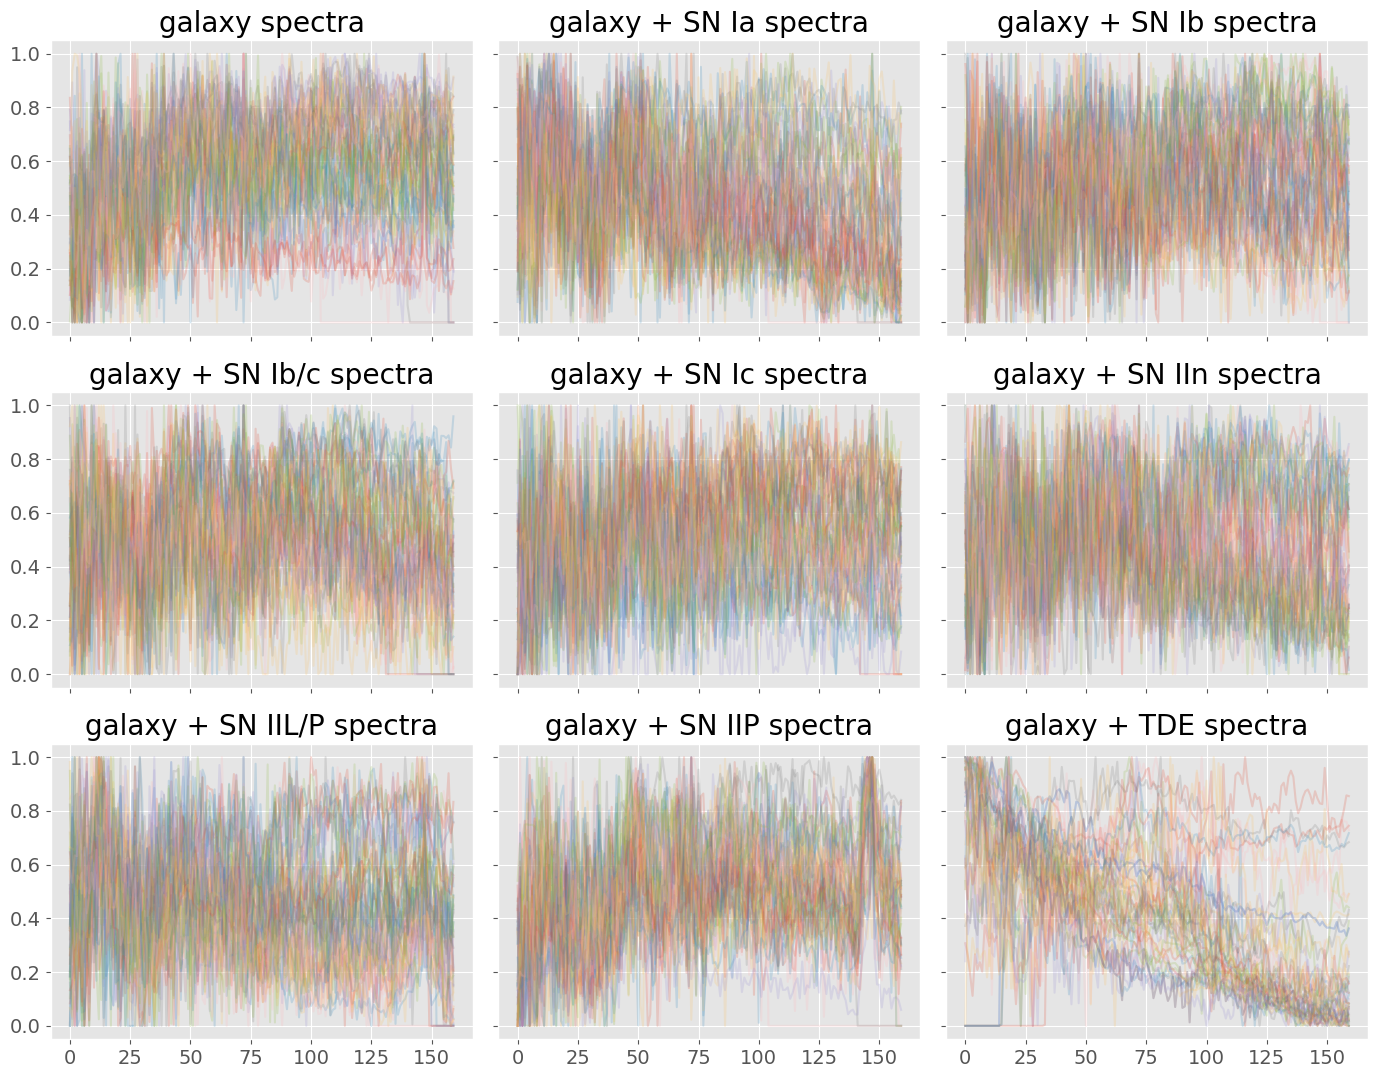

In [25]:
fig, axes = plt.subplots(3,3, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,56):
    
    ax = axes[0]
    ax.plot(galaxy_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snibc_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniin_flux[i], alpha=0.2)

    ax = axes[6]
    ax.plot(sniilp_flux[i], alpha=0.2)
    
    ax = axes[7]
    ax.plot(sniip_flux[i], alpha=0.2)
    
    ax = axes[8]
    ax.plot(tde_flux[i], alpha=0.2)
    
axes[0].set_title('galaxy spectra')
axes[1].set_title('galaxy + SN Ia spectra')
axes[2].set_title('galaxy + SN Ib spectra')
axes[3].set_title('galaxy + SN Ib/c spectra')
axes[4].set_title('galaxy + SN Ic spectra')
axes[5].set_title('galaxy + SN IIn spectra')
axes[6].set_title('galaxy + SN IIL/P spectra')
axes[7].set_title('galaxy + SN IIP spectra')
axes[8].set_title('galaxy + TDE spectra')

fig.tight_layout()

In [26]:
x = np.concatenate([galaxy_flux, 
                    snia_flux,
                    snib_flux,
                    snibc_flux,
                    snic_flux,
                    sniin_flux,
                    sniilp_flux,
                    sniip_flux,
                    kn_flux,
                    tde_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Galaxy',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP',
          'KN',
          'TDE']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(ngalaxy, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnibc, 3),
                        np.full(nsnic, 4),
                        np.full(nsniin, 5),
                        np.full(nsniilp, 6),
                        np.full(nsniip, 7),
                        np.full(nkn, 8),
                        np.full(ntde, 9)
                       ]))

In [30]:
np.save("x", x)
np.save("y", y)
np.save("labels", labels)

In [29]:
n_sample = [ngalaxy, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nkn, ntde]
weights = np.max(n_sample) / n_sample
class_weight = {}
for i in range(len(weights)):
    class_weight[i] = weights[i]
class_weight

{0: 1.0002006219279767,
 1: 1.0007025291047773,
 2: 1.0013054830287207,
 3: 1.0,
 4: 1.2058289998790663,
 5: 1.0022112775153282,
 6: 1.002312022517089,
 7: 1.0009034330455733,
 8: 1.1144517715435343,
 9: 178.05357142857142}

In [35]:
x.shape, y.shape

((86993, 150, 1), (86993, 10))

In [115]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

In [136]:
def network(input_shape, ncat, learning_rate=0.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [142]:
model = network((nbins, 1), ncat=y.shape[1])
model.summary()

Model: "SNnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Spec (InputLayer)     [(None, 150, 1)]          0         
                                                                 
 conv1d_24 (Conv1D)          (None, 150, 8)            48        
                                                                 
 batch_normalization_24 (Bat  (None, 150, 8)           32        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 150, 8)            0         
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 75, 8)            0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 75, 16)            656   

In [144]:
batch = 5
epoch = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=40)
mc = ModelCheckpoint('b{}_e{}_best_model.h5'.format(batch, epoch), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
hist = model.fit(x_train, y_train, batch_size=batch, epochs=epoch, validation_data=(x_test, y_test), shuffle=True, verbose=True, callbacks=[es, mc], class_weight=class_weight)

Epoch 1/200
13042/13049 [============================>.] - ETA: 0s - loss: 3.8681 - accuracy: 0.3437
Epoch 1: val_loss improved from inf to 3.18315, saving model to b5_e200_best_model.h5
13049/13049 [==============================] - 31s 2ms/step - loss: 3.8679 - accuracy: 0.3437 - val_loss: 3.1832 - val_accuracy: 0.4340
Epoch 2/200
 1681/13049 [==>...........................] - ETA: 24s - loss: 4.1090 - accuracy: 0.3058

KeyboardInterrupt: 

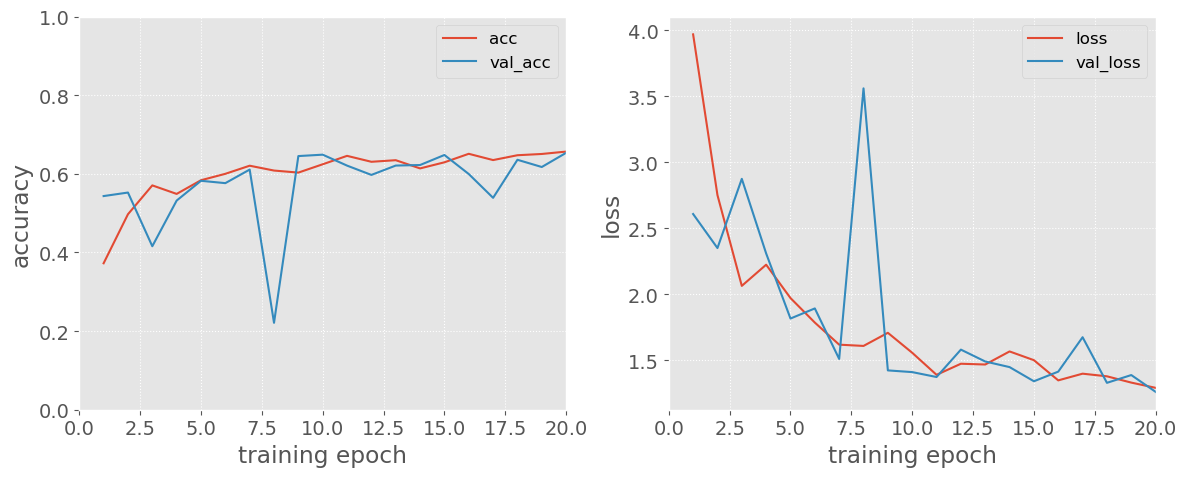

In [120]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout()
plt.savefig('b{}_e{}_accuracy.png'.format(batch, epoch))

In [121]:
y_pred = model.predict(x_test)
y_pred

272/272 [==============================] - 1s 1ms/step


array([[7.50094950e-01, 2.40976661e-02, 5.38194366e-02, ...,
        6.84990883e-02, 2.48662941e-02, 7.49611121e-04],
       [2.01901510e-01, 1.32660512e-02, 1.67369887e-01, ...,
        1.54992789e-01, 1.20533202e-02, 8.66427363e-05],
       [7.24001005e-02, 5.96405193e-02, 1.91266060e-01, ...,
        1.99204218e-02, 8.02463293e-03, 3.44745186e-03],
       ...,
       [2.53157719e-04, 9.85310912e-01, 6.20747509e-04, ...,
        1.03378610e-04, 4.86657482e-05, 4.08945738e-07],
       [1.08093195e-01, 8.98981169e-02, 9.29824933e-02, ...,
        7.06470981e-02, 8.67125019e-02, 2.26686765e-02],
       [1.79349536e-06, 7.69347253e-09, 3.42233907e-05, ...,
        9.99946713e-01, 1.69114585e-07, 4.11100302e-07]], dtype=float32)

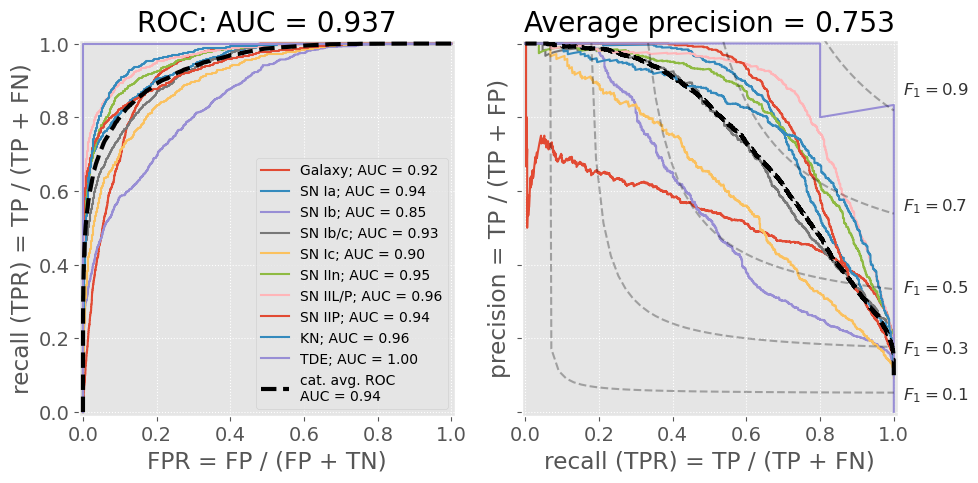

In [128]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()
plt.savefig('b{}_e{}_metrics.png'.format(batch, epoch))

In [129]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [130]:
labels

['Galaxy',
 'SN Ia',
 'SN Ib',
 'SN Ib/c',
 'SN Ic',
 'SN IIn',
 'SN IIL/P',
 'SN IIP',
 'KN',
 'TDE']

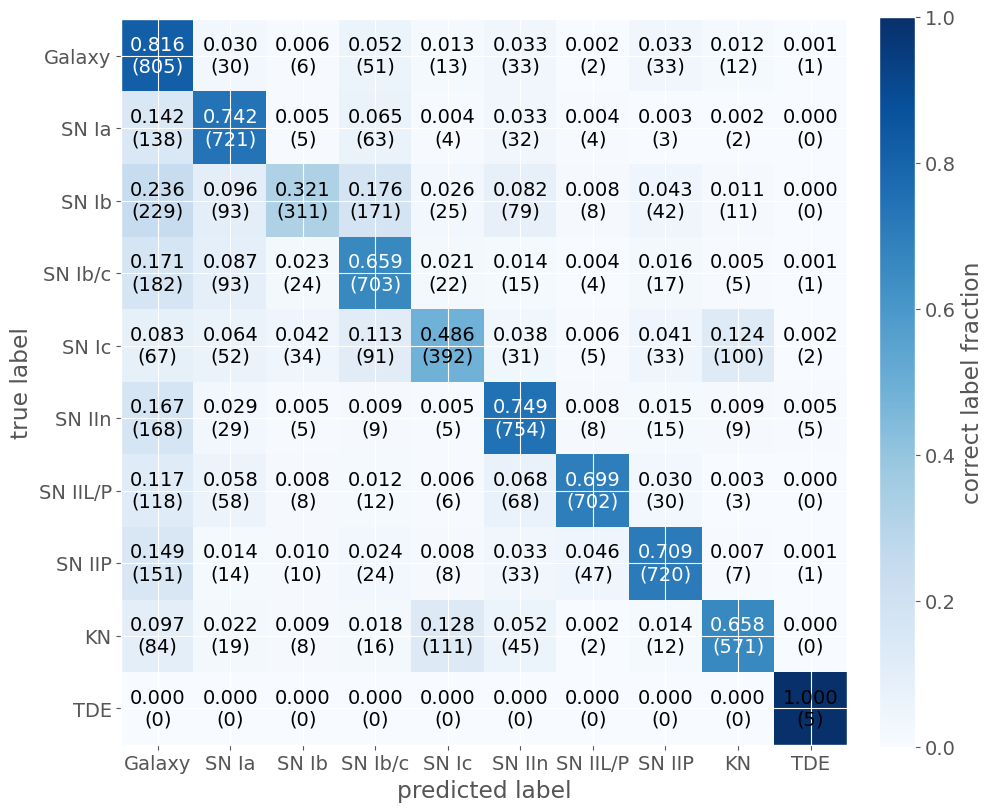

In [131]:
fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

plt.tight_layout()
plt.savefig('b{}_e{}_matrix.png'.format(batch, epoch))